In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
sys.path.insert(0, '../scripts')
from utils import *

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [4]:
plt.rcParams['figure.figsize'] = (12, 10)

In [5]:
train_data = pd.read_csv('../data/clean-train.csv').dropna(axis=0)
test_data = pd.read_csv('../data/clean-test.csv').dropna(axis=0)

In [6]:
q1_list = train_data['q1'].tolist()
q2_list = train_data['q2'].tolist()

In [7]:
vocab_size = 10000

In [8]:
token = Tokenizer(nb_words=vocab_size)
token.fit_on_texts(q1_list + q2_list)

/usr/local/lib/python3.5/dist-packages/keras/preprocessing/text.py:145: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [9]:
question1_seq = token.texts_to_sequences(q1_list)
question2_seq = token.texts_to_sequences(q2_list)

In [10]:
unique_words = {}

for sent in q1_list+q2_list:
    for word in sent.split(' '):
        unique_words[word] = 1.

In [12]:
MAX_SEQUENCE_LENGTH = 25

In [13]:
q1_data = pad_sequences(question1_seq, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(question2_seq, maxlen=MAX_SEQUENCE_LENGTH)

In [14]:
import gensim
from gensim.models import word2vec, Word2Vec

In [15]:
def get_vecs(q1, q2):
    vecs_q1 = []
    vecs_q2 = []

    for i, j in zip(q1, q2):
        vecs_q1.append(sum(model.word_vec(x) if x in model.vocab else np.zeros(300) for x in i))
        vecs_q2.append(sum(model.word_vec(x) if x in model.vocab else np.zeros(300) for x in j))
        
    return np.array(vecs_q1), np.array(vecs_q2)

In [16]:
model = gensim.models.KeyedVectors.load_word2vec_format('../data/glove.w2v.txt')

In [17]:
embed = np.empty((len(unique_words.keys()), 300))

for i, word in enumerate(unique_words.keys()):
    embed[i, :] = model.word_vec(word) if word in model.vocab else np.zeros(300)

In [23]:
from parikh import build_model

In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [29]:
decomposable_model = build_model(embed, num_class=1, maxlen=25)

In [30]:
decomposable_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [ ]:
callbacks = [ModelCheckpoint('../Saved Models/decomposable-noattention', monitor='val_acc', save_best_only=True),
            EarlyStopping(monitor='val_acc', patience=2)]
decomposable_model.fit([q1_data, q2_data], train_data['is_same'], validation_split=0.1, epochs=100,
                      callbacks=callbacks)

Train on 291067 samples, validate on 32341 samples
Epoch 1/100
291067/291067 [==============================] - 855s 3ms/step - loss: 0.5524 - acc: 0.7069 - val_loss: 0.5196 - val_acc: 0.7267
Epoch 2/100
291067/291067 [==============================] - 1126s 4ms/step - loss: 0.5184 - acc: 0.7296 - val_loss: 0.5016 - val_acc: 0.7375
Epoch 3/100
 58240/291067 [=====>........................] - ETA: 14:32 - loss: 0.5036 - acc: 0.7385

In [36]:
q1_list_test = test_data['q1'].tolist()
q2_list_test = test_data['q2'].tolist()

question1_seq_test = token.texts_to_sequences(q1_list_test)
question2_seq_test = token.texts_to_sequences(q2_list_test)

q1_data_test = pad_sequences(question1_seq_test, maxlen=MAX_SEQUENCE_LENGTH)
q2_data_test = pad_sequences(question2_seq_test, maxlen=MAX_SEQUENCE_LENGTH)

test_labels = test_data['is_same'].values

In [39]:
preds = decomposable_model.predict([q1_data_test, q2_data_test])

In [40]:
classes = (preds > 0.5).astype('int').flatten()

In [41]:
generate_report(test_labels, classes.flatten(), preds.flatten())

Loss Report
-----------

Accuracy Score: 0.7494
ROC  AUC Score: 0.8306
Log Loss Score: 0.4815


(0.74944962525045145, 0.83059159584317688, 0.48152145289900378)

In [136]:
from keras.models import Sequential

In [140]:
decomposable_model.count_params()

30770801

In [66]:
attn_1 = Model(inputs=decomposable_model.input,
                                 outputs=decomposable_model.layers[8].output)
attn_1_out = attn_1.predict([q1_data_test[:100], q2_data_test[:100]])

In [67]:
attn_2 = Model(inputs=decomposable_model.input,
                                 outputs=decomposable_model.layers[10].output)
attn_2_out = attn_2.predict([q1_data_test[:100], q2_data_test[:100]])

In [120]:
idx = test_data['is_same'][:100][test_data['is_same'][:100] > 0].index.tolist()

In [121]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [122]:
def get_sentence(sent):
    if len(sent.split(' ')) < 25:
        temp = ['<UNK>'] * (25 - len(sent.split(' '))) + sent.split(' ')
        return temp
    else:
        return sent.split(' ')[:25]

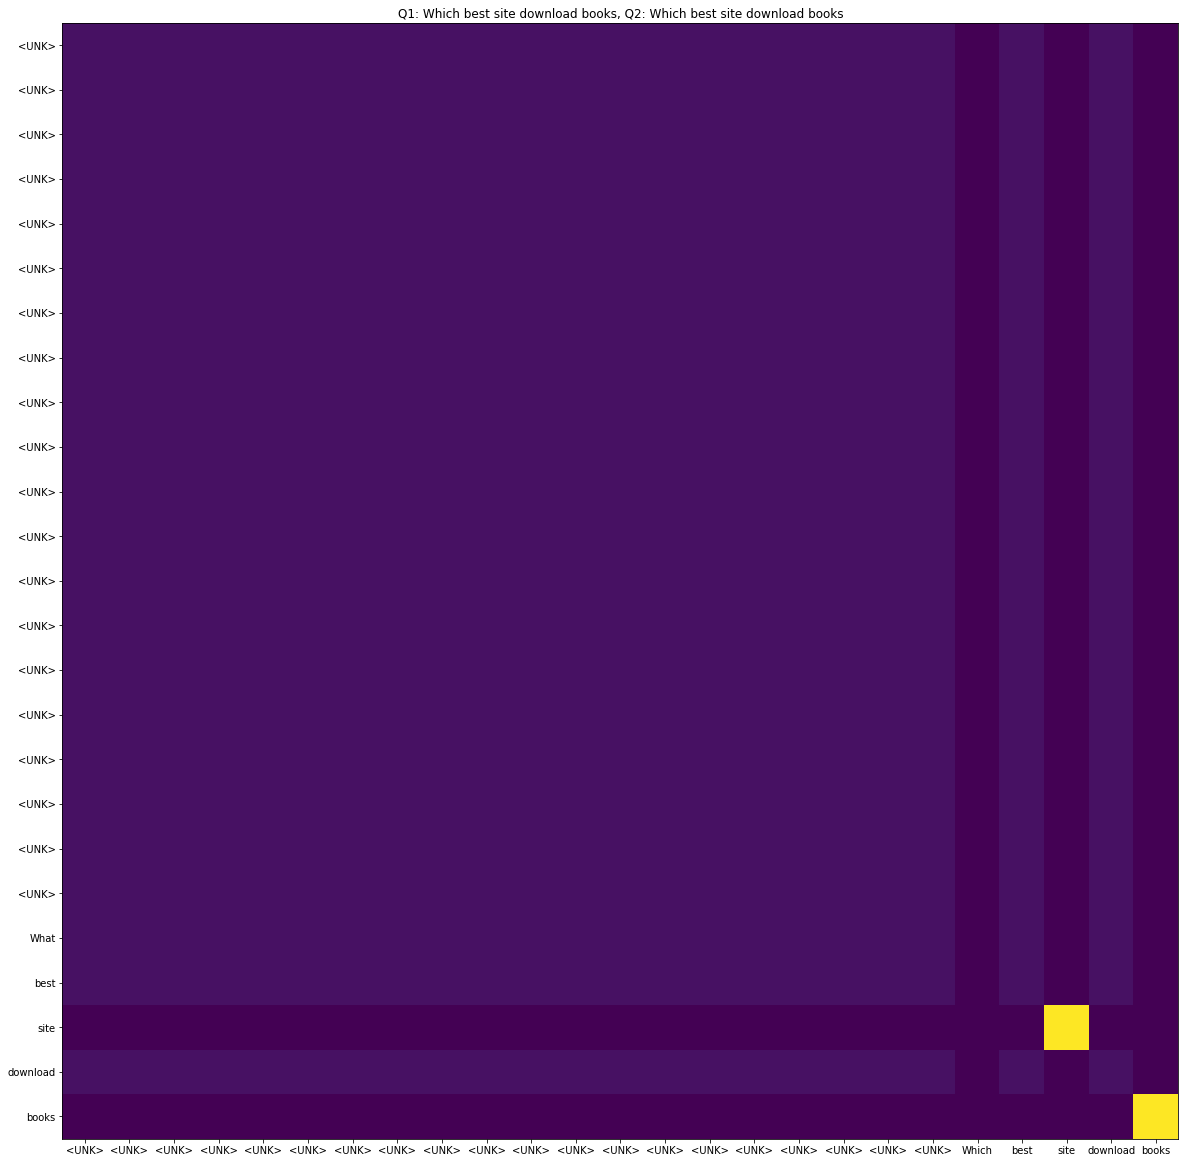

In [134]:
i = np.random.choice(idx)

fig = plt.figure(figsize=(20, 60))
sent1 = get_sentence(q1_list_test[i])
sent2 = get_sentence(q2_list_test[i])

im = plt.imshow(attn_1_out[i], cmap='viridis')
plt.title('Q1: ' + q1_list_test[i] + ', Q2: ' + q1_list_test[i])
plt.xticks(np.arange(25), sent1)
plt.yticks(np.arange(25), sent2);
plt.savefig('../images/no-train-example.png')